In [54]:
from __future__ import print_function
from __future__ import division
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import pytesseract
from pytesseract import Output
import argparse

In [55]:
# ---image processing function
def plotimage(title,img,colormap):
    print("plot image :",title)
    plotting = plt.imshow(img, cmap=colormap)
    plt.show()

def resizeImage(img,scale):
    print("resize image")
    # resize image
    scale_ratio = scale
    height = int(img.shape[0] * scale_ratio)
    width = int(img.shape[1] * scale_ratio)
    img = cv2.resize(img, (width,height), interpolation=cv2.INTER_AREA)
    return img

def saveImage(name,image):
    path = '/Users/sutimarpengpinij/Desktop/204491_Independence/handwritten-recognize-491/output'
    cv2.imwrite(path+'/'+name, image)
    print('writing image in ',path)

def showHistogram(img):
    if img is None:
        print('Could not open or find the image')
    
    bgr_planes = cv2.split(img)
    histogram_size = 256
    histogram_range = (0,256)

    accumulate = False
    blue_hist = cv2.calcHist(bgr_planes, [0], None, [histogram_size], histogram_range, accumulate=accumulate)
    green_hist = cv2.calcHist(bgr_planes, [1], None, [histogram_size], histogram_range, accumulate=accumulate)
    red_hist = cv2.calcHist(bgr_planes, [2], None, [histogram_size], histogram_range, accumulate=accumulate)

    print('pass ---')

    display_w = 512
    display_h = 400
    bin_w = int(round(display_w/ histogram_size))
    histograme_image = np.zeros((display_h, display_w,3), dtype=np.uint8)

    cv2.normalize(blue_hist, blue_hist, alpha=0, beta=display_h, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(green_hist, green_hist, alpha=0, beta=display_h, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(red_hist, red_hist, alpha=0, beta=display_h, norm_type=cv2.NORM_MINMAX)

    for i in range(1, histogram_size):
        cv2.line(histograme_image, ( bin_w*(i-1), display_h - int(np.round(blue_hist[i-1])) ),
            ( bin_w*(i), display_h - int(np.round(blue_hist[i])) ),
            ( 255, 0, 0), thickness=2)
        cv2.line(histograme_image, ( bin_w*(i-1), display_h - int(np.round(green_hist[i-1])) ),
            ( bin_w*(i), display_h - int(np.round(green_hist[i])) ),
            ( 0, 255, 0), thickness=2)
        cv2.line(histograme_image, ( bin_w*(i-1), display_h - int(np.round(red_hist[i-1])) ),
            ( bin_w*(i), display_h - int(np.round(red_hist[i])) ),
            ( 0, 0, 255), thickness=2)

    # cv2.imshow('histograme',histograme_image)
    # cv2.waitKey(0)
    plotimage('histogram image',histograme_image,'jet')

def sortContours(cnts, method='left-to-right'):

    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if (method == 'right-to-left' or method == 'bottom-to-top'):
        reverse = True
    
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if (method == 'top-to-bottom' or method == 'bottom-to-top'):
        i = 1
    
    # construct the list of bounding boxes and sort them from top to
    # bottom 
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b:b[1][i], reverse=reverse))

    return (cnts, boundingBoxes)



plot image : img Q


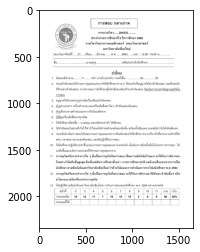

In [56]:
# ---import image
imgQ = cv2.imread('../image/midterm-score/midterm-score.jpg',0)
imgtest = cv2.imread('../image/hist_test.jpg')
plotimage('img Q',imgQ, 'gray')
#showHistogram(imgtest)


plot image : imgQ keypoint


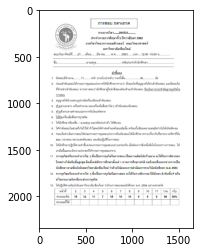

In [57]:
# -- warp Image
# ---faeture of query image

orb = cv2.ORB_create(nfeatures=1000)
kp1, des1 = orb.detectAndCompute(imgQ, None)
imgKp1 = cv2.drawKeypoints(imgQ,kp1,None)

plotimage('imgQ keypoint',imgKp1, 'gray')

plot image : img form


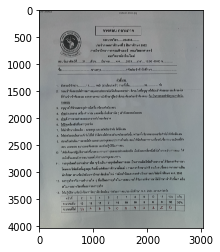

In [58]:
# ---import user forms
img = cv2.imread('../image/userForms-image/test8.jpg')
plotimage('img form', img, 'gray')

plot image : img matching


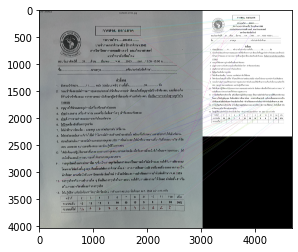

In [59]:
# ---find the feature
kp2, des2 = orb.detectAndCompute(img, None)

# ---Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.match(des2, des1)

# ---Right after matching we will sort out the best matches and store them in a list by the name good. Let’s have a look at one of these matches.
persen = 5
matches.sort(key = lambda x:x.distance)
good = matches[:int(len(matches) * (persen/100))]
imgMatches = cv2.drawMatches(img, kp2, imgQ, kp1, good, None, flags=2)

plotimage('img matching',imgMatches, 'gray')

finish scan !!!
plot image : img scan


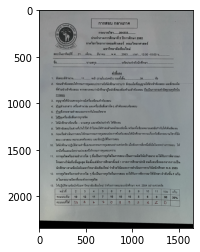

In [60]:
# --- scan or wrap
# --- Aligning The Forms Since the our user forms are not in the correct alignment, we cannot extract the text information yet. So we will first align these images using the key points from both our images.
# --- Given we have a few points in our user form and the location of same points in the query image we can find the relationship between them. This relationship is basically a matrix, and the process of finding it is know as Homography. Using this relationship we can align our user form.

srcPts = np.float32([kp2[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dstPts = np.float32([kp1[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
M, _ = cv2.findHomography(srcPts, dstPts, cv2.RANSAC, 5.0)

h, w = imgQ.shape[:2]
imgScan = cv2.warpPerspective(img, M, (w, h))

print('finish scan !!!')
plotimage('img scan', imgScan, 'gray')

plot image : img roi


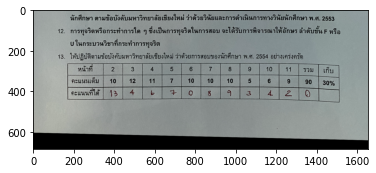

writing image in  /Users/sutimarpengpinij/Desktop/204491_Independence/handwritten-recognize-491/output


In [61]:
img = imgScan

x, y, channel = img.shape

# roi
img = img[y:,:]
plotimage('img roi', img, 'gray')
saveImage('roi.jpg',img)

plot image : gray image


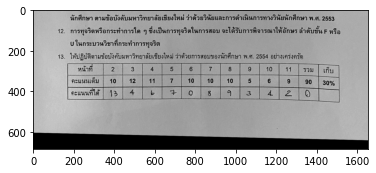

plot image : threshold


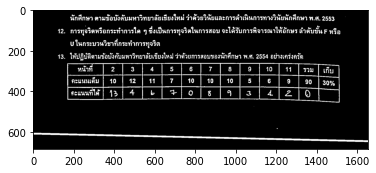

plot image : image vertical line


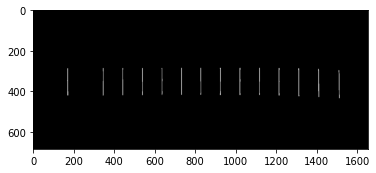

writing image in  /Users/sutimarpengpinij/Desktop/204491_Independence/handwritten-recognize-491/output
plot image : image horizontal line


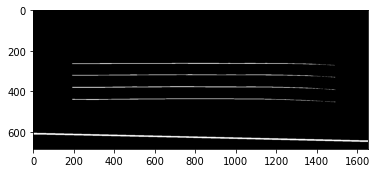

writing image in  /Users/sutimarpengpinij/Desktop/204491_Independence/handwritten-recognize-491/output
writing image in  /Users/sutimarpengpinij/Desktop/204491_Independence/handwritten-recognize-491/output
plot image : image vertival and horizontal line


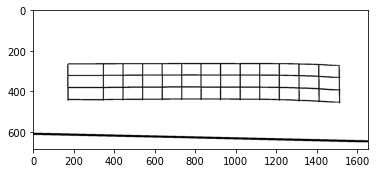

plot image : bit xor


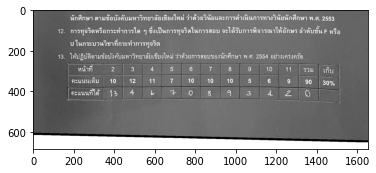

plot image : bit nor


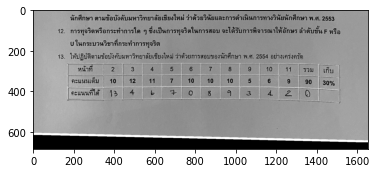

In [100]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plotimage('gray image', gray_img, 'gray')


#blur
blur = cv2.GaussianBlur(gray_img,(5,5),0)
#thresholding
thresh = cv2.adaptiveThreshold(blur,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,35,10)
plotimage('threshold', thresh, 'gray')

# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))

#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(thresh, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
plotimage('image vertical line', image_1, 'gray')
saveImage('vertical_line.jpg', image_1)

#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(thresh, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
plotimage('image horizontal line', image_2, 'gray')
saveImage('horizontal_line.jpg', image_2)

# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
saveImage('vh_line.jpg', img_vh)

#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plotimage('image vertival and horizontal line', img_vh, 'gray')


bitxor = cv2.bitwise_xor(gray_img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
plotimage('bit xor',bitxor,'gray')
plotimage('bit nor', bitnot, 'gray')

In [149]:
from keras.models import load_model

model = load_model('/Users/sutimarpengpinij/Desktop/python/handwriting-recog/mnist.h5')

print('success load model')
print(model)

success load model


plot image : mask


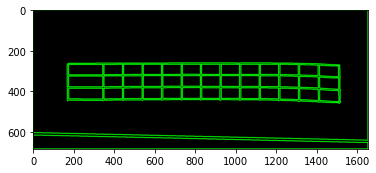

plot image : box : 2 height : 28 width : 28


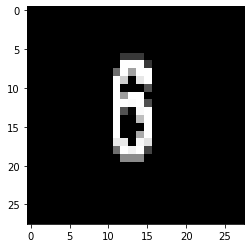

predict number : [5]
plot image : box : 3 height : 28 width : 28


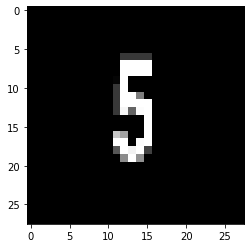

predict number : [2]
plot image : box : 4 height : 28 width : 28


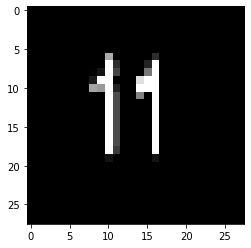

predict number : [2]
plot image : box : 5 height : 28 width : 28


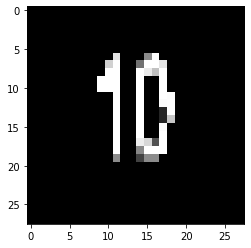

predict number : [8]
plot image : box : 6 height : 28 width : 28


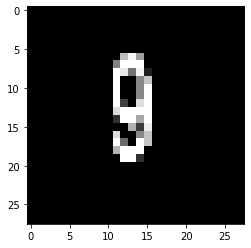

predict number : [0]
plot image : box : 7 height : 28 width : 28


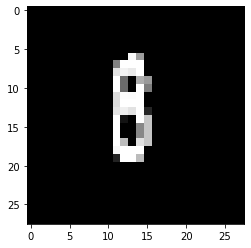

predict number : [0]
plot image : box : 8 height : 28 width : 28


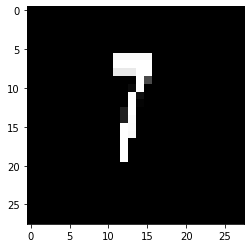

predict number : [8]
plot image : box : 9 height : 28 width : 28


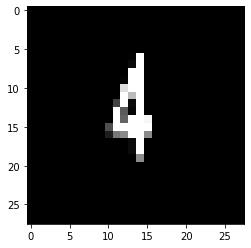

predict number : [5]
plot image : box : 10 height : 28 width : 28


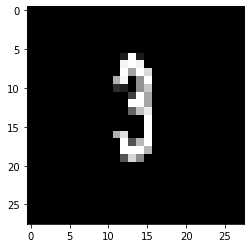

predict number : [2]
plot image : box : 11 height : 28 width : 28


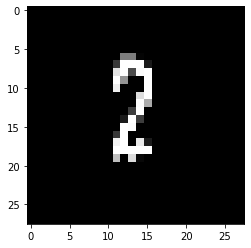

predict number : [4]
plot image : box : 12 height : 28 width : 28


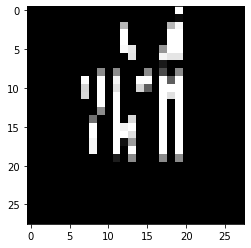

predict number : [6]
plot image : box : 13 height : 28 width : 28


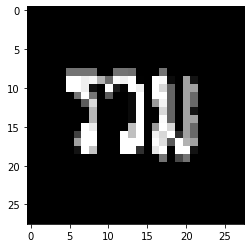

predict number : [2]
plot image : box : 14 height : 28 width : 28


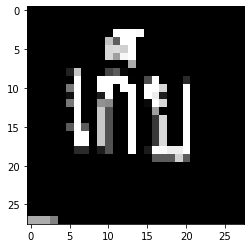

predict number : [5]
plot image : box : 15 height : 28 width : 28


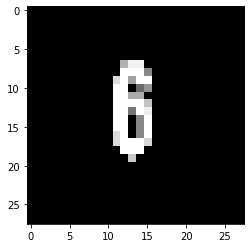

predict number : [3]
plot image : box : 16 height : 28 width : 28


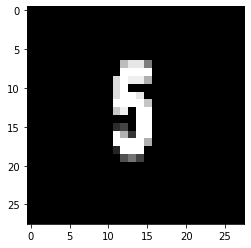

predict number : [9]
plot image : box : 17 height : 28 width : 28


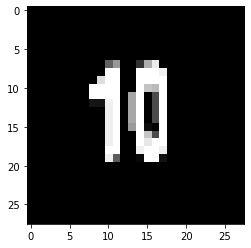

predict number : [8]
plot image : box : 18 height : 28 width : 28


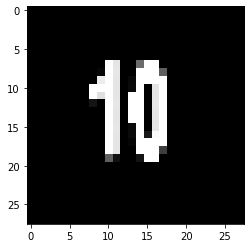

predict number : [8]
plot image : box : 19 height : 28 width : 28


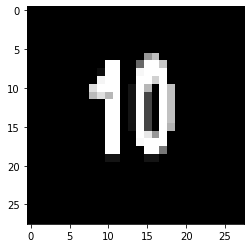

predict number : [0]
plot image : box : 20 height : 28 width : 28


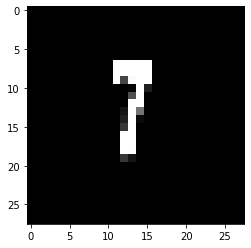

predict number : [2]
plot image : box : 21 height : 28 width : 28


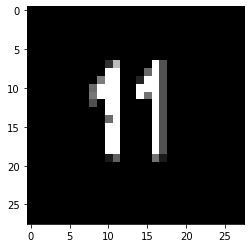

predict number : [2]
plot image : box : 22 height : 28 width : 28


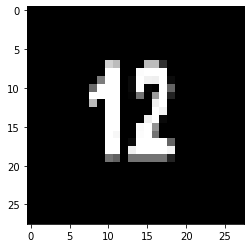

predict number : [9]
plot image : box : 23 height : 28 width : 28


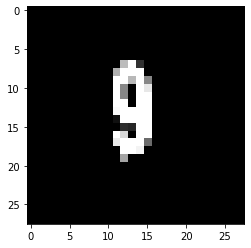

predict number : [0]
plot image : box : 24 height : 28 width : 28


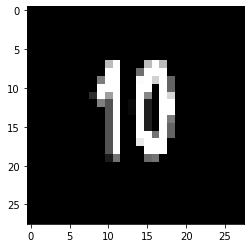

predict number : [8]
plot image : box : 25 height : 28 width : 28


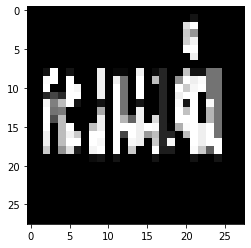

predict number : [5]
plot image : box : 26 height : 28 width : 28


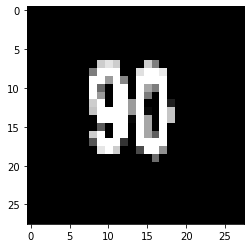

predict number : [5]
plot image : box : 27 height : 28 width : 28


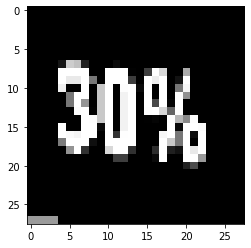

predict number : [7]
plot image : box : 28 height : 28 width : 28


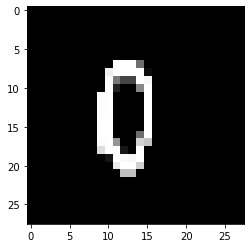

predict number : [8]
plot image : box : 29 height : 28 width : 28


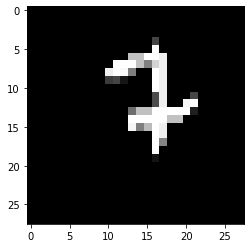

predict number : [9]
plot image : box : 30 height : 28 width : 28


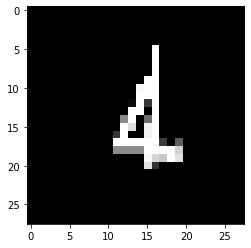

predict number : [2]
plot image : box : 31 height : 28 width : 28


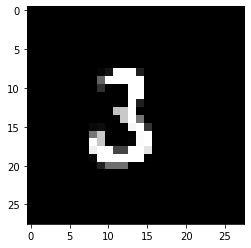

predict number : [9]
plot image : box : 32 height : 28 width : 28


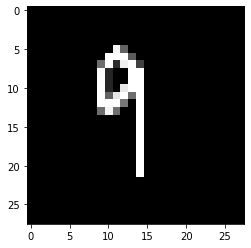

predict number : [2]
plot image : box : 33 height : 28 width : 28


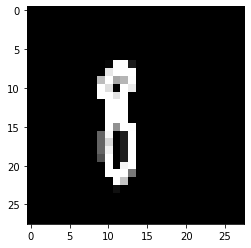

predict number : [7]
plot image : box : 34 height : 28 width : 28


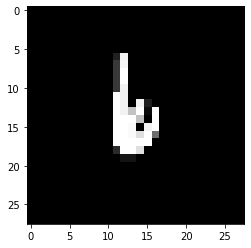

predict number : [0]
plot image : box : 35 height : 28 width : 28


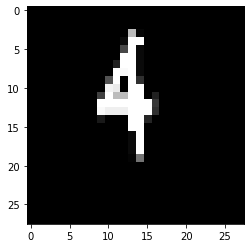

predict number : [2]
plot image : box : 36 height : 28 width : 28


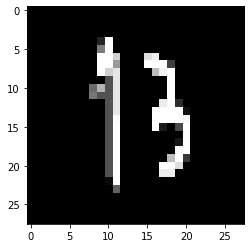

predict number : [5]
plot image : box : 37 height : 28 width : 28


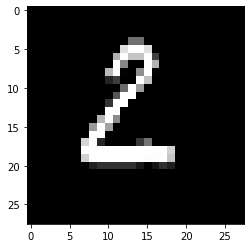

predict number : [3]
plot image : box : 38 height : 28 width : 28


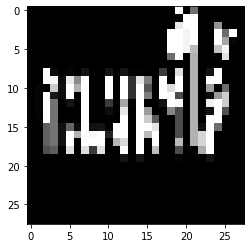

predict number : [7]
plot image : box : 39 height : 28 width : 28


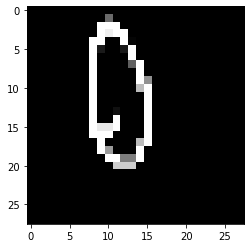

predict number : [1]
plot image : box : 40 height : 28 width : 28


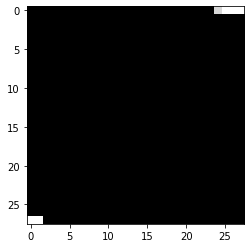

predict number : [1]
plot image : image contours


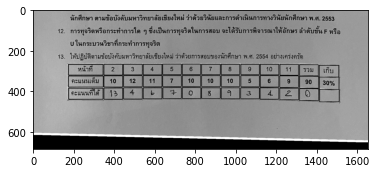

In [150]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(mask, contours, -1, (0, 255, 0), 3)
plotimage('mask',mask, 'gray')

# sort all the contours
contours, boundingBoxes = sortContours(contours, method='top-to-bottom')

#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

#Create list box to store all boxes in 
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for i in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[i])

    if (w<200 and h<200):
        #image = cv2.rectangle(bitnot,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])

        b = img[y+3:y+h-3 , x+5:x+w-5]
        b = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
        ret, b = cv2.threshold(b, 100, 255, cv2.THRESH_BINARY_INV)
        b = 255 - b
    
        b = cv2.resize(b, (28,28))

        #saveImage(name, b)
        title_box = "box : "+ str(i) + ' height : ' + str(b.shape[0]) + ' width : '+str(b.shape[1])

        ans = model.predict(b.reshape(1,28,28,1))

        plotimage(title_box, b, 'Greys')
        print('predict number : {}'.format(np.argmax(ans, axis=1)))
        #name = 'box '+str(i)+'.jpg'
        

plotimage('image contours',image, 'gray')

In [134]:
#Creating two lists to define row and column in which cell is located

row = []
column = []
j = 0

for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous = box[i]
    else:
        if(box[i][1] <= previous[1] + mean/2):
            column.append(box[i])
            previous = box[i]

            if(i==len(box)-1):
                row.append(column)  
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(len(column))
print(len(row))


13
3
